# SPARK hackfest-in-a-box for FinTech - LAB 1

The objetive is this lab is to perform exploratory data analysis and data preparation on a fintech dataset (blockchain) for detecting if a transactions are coming from a mining pool.

Bitcoin mining pools are networks of distributed Bitcoin miners who cooperate to mine blocks together and distribute the payments based on each entity's contribution to the pool. This allows miners to smooth out their revenue at a slight discount in the form of fees paid to the pool coordinator.

 - This notebook Based on the Kaggle kernels [Bitcoin insights](https://www.kaggle.com/code/rakibfiha/bitcoin-insights) and [Mining Pool Classifier](https://www.kaggle.com/code/wprice/bitcoin-mining-pool-classifier).
 - Main Changes:
     - Refactor due to update old Public Dataset (`bigquery-public-data.bitcoin_blockchain` to `bigquery-public-data.crypto_bitcoin`)
     - Refactor from BigQuery to pySPARK
     - Refactor the ML part from `sci-kit-learn` to `SPARK mllib`

## 1 Exploratory data analysis

In statistics, exploratory data analysis (EDA) is an approach of analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods

In [ ]:
project_id = "YOUR_PROJECT_ID"

In [ ]:
#%%bigquery
#CREATE  SCHEMA crypto_bitcoin;
#CREATE OR REPLACE TABLE crypto_bitcoin.transactions AS (SELECT * FROM bigquery-public-data.crypto_bitcoin.transactions TABLESAMPLE SYSTEM (0.0001 PERCENT));
#CREATE OR REPLACE TABLE crypto_bitcoin.blocks AS ( SELECT * FROM bigquery-public-data.crypto_bitcoin.transactions TABLESAMPLE SYSTEM (0.0001 PERCENT));

In [114]:
import sys
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [115]:
spark = SparkSession.builder.getOrCreate()

#### Question 1: Find Bitcoins public addresses (wallets) who has received most number of bitcoins

In [116]:
#The BigQuery Storage API supports predicate push-down of filters which means that if you set a filter in the where statement 
#later on in your Apache Spark job it will attempt to push the filter to BigQuery.
#For most use cases the default setting of attempting to read one partition per 400MB should be adequate.
#Currently the maximum parallelism allowed by the BigQuery storage API is 1000
max_bc_df = spark.read.format('bigquery') \
  .option('table', '{}.crypto_bitcoin.transactions'.format(project_id))  \
  .load()

In [117]:
# Show table schema
max_bc_df.printSchema()

root
 |-- hash: string (nullable = true)
 |-- size: long (nullable = true)
 |-- virtual_size: long (nullable = true)
 |-- version: long (nullable = true)
 |-- lock_time: long (nullable = true)
 |-- block_hash: string (nullable = true)
 |-- block_number: long (nullable = true)
 |-- block_timestamp: timestamp (nullable = true)
 |-- block_timestamp_month: date (nullable = true)
 |-- input_count: long (nullable = true)
 |-- output_count: long (nullable = true)
 |-- input_value: decimal(38,9) (nullable = true)
 |-- output_value: decimal(38,9) (nullable = true)
 |-- is_coinbase: boolean (nullable = true)
 |-- fee: decimal(38,9) (nullable = true)
 |-- inputs: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- index: long (nullable = true)
 |    |    |-- spent_transaction_hash: string (nullable = true)
 |    |    |-- spent_output_index: long (nullable = true)
 |    |    |-- script_asm: string (nullable = true)
 |    |    |-- script_hex: string (nullable = tr

In [118]:
#Unnest inputs and outputs arrays - It is important to look at the BigQuery table structure (NESTED ARRAYS)
max_bc_df = max_bc_df.withColumn("o", F.explode("outputs")).withColumn("i", F.explode("inputs"))
max_bc_df = max_bc_df.withColumn("o_address", F.explode("o.addresses")).withColumn("i_address", F.explode("i.addresses"))

In [119]:
#~ is the not is in operator, different outputs and inputs
max_bc_df = max_bc_df.where( ~ max_bc_df.o_address.isin(max_bc_df.i_address))

In [120]:
#Remember that 1 bc = 100000000 satoshis
max_bc_df = max_bc_df.groupBy("o_address") \
    .agg((F.sum("o.value")/100000000) \
    .alias("output_sum"))

In [121]:
max_bc_df = max_bc_df.orderBy(max_bc_df.output_sum.desc()).limit(1000) \
    .select("o_address", "output_sum")

In [122]:
%%time
#Triggers the DAG exec.
max_bc_df_pd = max_bc_df.toPandas()

[Stage 247:==============================================>      (176 + 4) / 200]

CPU times: user 27.1 ms, sys: 8 ms, total: 35.1 ms
Wall time: 5.42 s


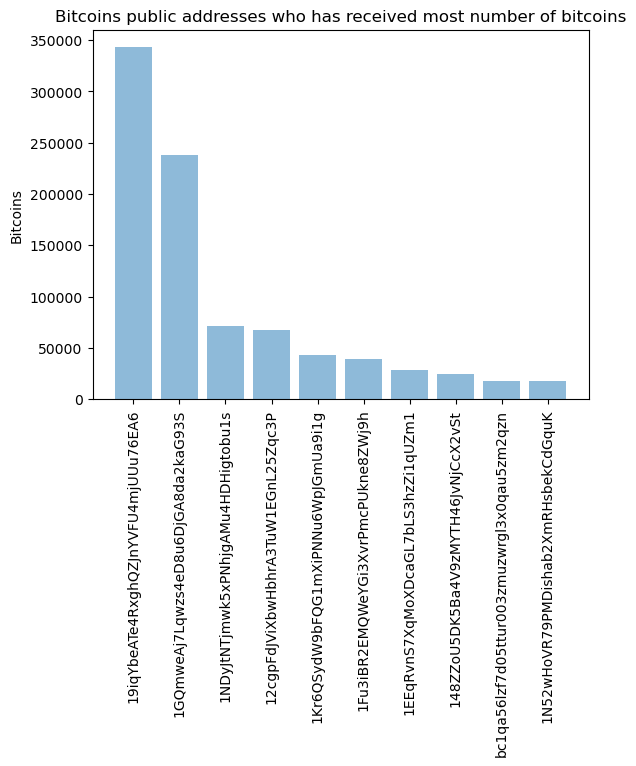

In [123]:
objects = max_bc_df_pd["o_address"][:10]
y_pos = np.arange(len(objects))
performance = max_bc_df_pd["output_sum"][:10]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=90)
plt.ylabel('Bitcoins')
plt.title('Bitcoins public addresses who has received most number of bitcoins')
plt.show()

#### Question 2: Find the largest transactions to date

In [124]:
largest_bc_tx_df = spark.read.format('bigquery') \
  .option('table', '{}.crypto_bitcoin.transactions'.format(project_id))  \
  .load()

In [125]:
#Unnest inputs and outputs arrays
largest_bc_tx_df = largest_bc_tx_df.withColumn("o", F.explode("outputs")).withColumn("i", F.explode("inputs"))
largest_bc_tx_df = largest_bc_tx_df.withColumn("o_address", F.explode("o.addresses")).withColumn("i_address", F.explode("i.addresses"))
largest_bc_tx_df = largest_bc_tx_df.orderBy(largest_bc_tx_df.o.value.desc()).limit(100)
largest_bc_tx_df = largest_bc_tx_df.select("o_address", "o.value", "block_timestamp")

In [126]:
%%time
largest_bc_tx_df_pd = largest_bc_tx_df.toPandas()

[Stage 248:======================================>                  (2 + 1) / 3]

CPU times: user 17.2 ms, sys: 7.82 ms, total: 25 ms
Wall time: 3.48 s


In [127]:
largest_bc_tx_df_pd=largest_bc_tx_df_pd.drop_duplicates().sort_values(by="block_timestamp").astype({"value": float})
largest_bc_tx_df_pd['value'] = largest_bc_tx_df_pd['value'].div(100000000).round(2)
largest_bc_tx_df_pd['block_timestamp'] = pd.to_datetime(largest_bc_tx_df_pd['block_timestamp'],infer_datetime_format=True)

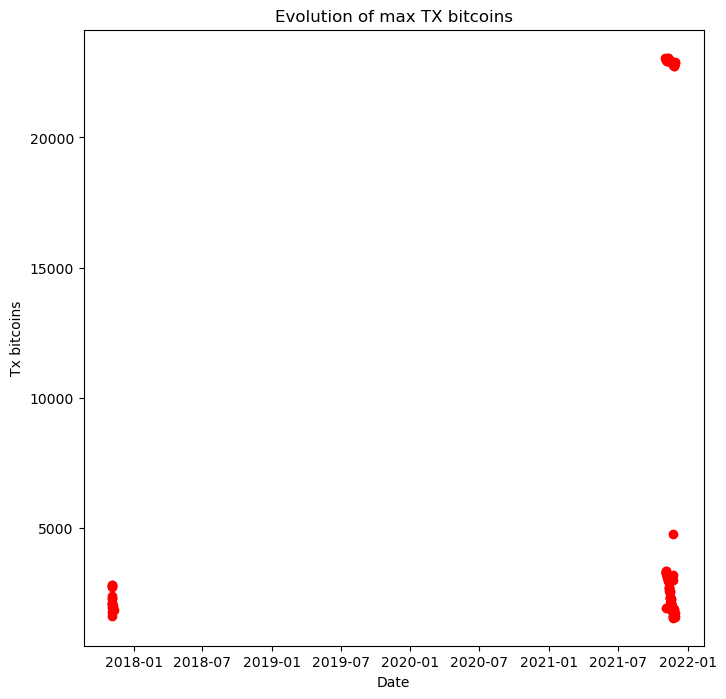

In [128]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(largest_bc_tx_df_pd['block_timestamp'],largest_bc_tx_df_pd['value'],color='red')
ax.set(xlabel="Date",ylabel="Tx bitcoins",title="Evolution of max TX bitcoins")
plt.show()

#### Question 3: Top 100 users paying more in self transactions fees

In [129]:
top_self_tx_fees_df = spark.read.format('bigquery') \
  .option('table', '{}.crypto_bitcoin.transactions'.format(project_id))  \
  .load()

In [130]:
top_self_tx_fees_df.createOrReplaceTempView("transactions")
spark.sql("DESCRIBE transactions").show()

+--------------------+--------------------+-------+
|            col_name|           data_type|comment|
+--------------------+--------------------+-------+
|                hash|              string|   null|
|                size|              bigint|   null|
|        virtual_size|              bigint|   null|
|             version|              bigint|   null|
|           lock_time|              bigint|   null|
|          block_hash|              string|   null|
|        block_number|              bigint|   null|
|     block_timestamp|           timestamp|   null|
|block_timestamp_m...|                date|   null|
|         input_count|              bigint|   null|
|        output_count|              bigint|   null|
|         input_value|       decimal(38,9)|   null|
|        output_value|       decimal(38,9)|   null|
|         is_coinbase|             boolean|   null|
|                 fee|       decimal(38,9)|   null|
|              inputs|array<struct<inde...|   null|
|           

In [131]:
%%time
top_self_tx_fees_df = spark.sql("""
    SELECT SUM(fee/100000000) as output_sum_fees, o_address
    FROM transactions
    LATERAL VIEW EXPLODE(outputs) exploded_outputs as o 
    LATERAL VIEW EXPLODE(o.addresses) exploded_address_o as o_address
WHERE o_address IN (
  SELECT i_address
  FROM transactions
  LATERAL VIEW EXPLODE(inputs) exploded_inputs as i 
  LATERAL VIEW EXPLODE(i.addresses) exploded_address_i as i_address
  )
AND size(o.addresses) = 1
GROUP BY o_address
ORDER BY output_sum_fees DESC
LIMIT 1000""").toPandas()
#JOIN UNNEST = LATERAL VIEW EXPLODE, similar in HIVE

CPU times: user 29.7 ms, sys: 923 µs, total: 30.7 ms
Wall time: 4.31 s


In [132]:
top_self_tx_fees_df.head(10)

,output_sum_fees,o_address
0,1.215967900,1N52wHoVR79PMDishab2XmRHsbekCdGquK
1,0.540000300,19xEKe1fkryQJTefL7oe4xybgfGxMrbLjF
2,0.474377870,12cgpFdJViXbwHbhrA3TuW1EGnL25Zqc3P
3,0.303589520,35iMHbUZeTssxBodiHwEEkb32jpBfVueEL
4,0.270000150,37zUXXygUCpDgkopsTSKyPZwFZHnBwB6MY
5,0.213306000,11UVRj5fa2w7HVgQ6XWjBYeJcTEXhZ9jN
6,0.212859120,1J37CY8hcdUXQ1KfBhMCsUVafa8XjDsdCn
7,0.180000100,35MnvAKDRaHjmH8AZsGnVScXVwQQpu9c34
8,0.180000100,3L9Wgxg3n5jWVuJbyGASWGPxFXRJXmutdh
9,0.180000100,1KsKCHonsSLjFeGCPaqb2tPh62eLJAPJQE


####  Question 4: Compute the average number of bitcoins transacted per day

In [133]:
avg_bc_txs_df = spark.read.format('bigquery') \
  .option('table', '{}.crypto_bitcoin.transactions'.format(project_id))  \
  .load()

In [134]:
avg_bc_txs_df = avg_bc_txs_df.withColumn("o", F.explode("outputs")).withColumn("o_address", F.explode("o.addresses"))
avg_bc_txs_df = avg_bc_txs_df.groupBy(F.to_date("block_timestamp").alias("date")) \
    .agg((F.avg("o.value")/100000000) \
    .alias("output_avg"))
avg_bc_txs_df = avg_bc_txs_df.orderBy(avg_bc_txs_df.output_avg.desc()).limit(5000) \
    .select("date", "output_avg")

In [135]:
%%time
avg_bc_txs_df_pd = avg_bc_txs_df.toPandas()

[Stage 253:>                                                        (0 + 1) / 1]

CPU times: user 11.4 ms, sys: 3.19 ms, total: 14.6 ms
Wall time: 2.06 s


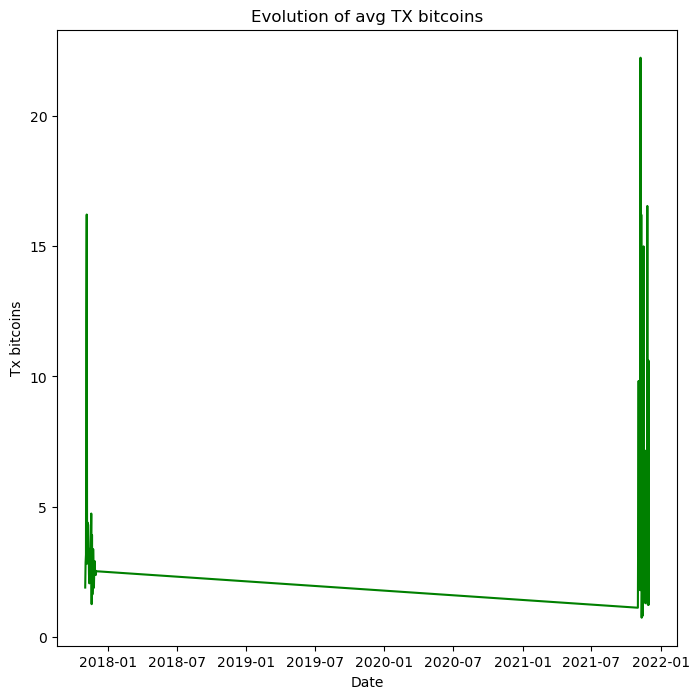

In [136]:
avg_bc_txs_df_pd=avg_bc_txs_df_pd.sort_values(by="date").astype({"output_avg": float})
avg_bc_txs_df_pd['date'] = pd.to_datetime(avg_bc_txs_df_pd['date'],infer_datetime_format=True)
fig, ax = plt.subplots(figsize=(8, 8))
#ax.plot(avg_bc_txs_df_pd['to_date(block_timestamp)'],avg_bc_txs_df_pd['output_avg'],color='green')
ax.plot(avg_bc_txs_df_pd['date'],avg_bc_txs_df_pd['output_avg'],color='green')
ax.set(xlabel="Date",ylabel="Tx bitcoins",title="Evolution of avg TX bitcoins")
plt.show()

####  Question 5: Lost wallets with more than 50 BTCs value

In [137]:
lost_wallets_df = spark.read.format('bigquery') \
  .option('table', '{}.crypto_bitcoin.transactions'.format(project_id))  \
  .load()

In [138]:
lost_wallets_df_inner = lost_wallets_df.withColumn("i", F.explode("inputs")).withColumn("i_address", F.explode("i.addresses"))
lost_wallets_df_inner = lost_wallets_df_inner.where(lost_wallets_df_inner.i_address.isNotNull()).select("i_address")

In [139]:
lost_wallets_df = lost_wallets_df.withColumn("o", F.explode("outputs")).withColumn("i", F.explode("inputs"))
lost_wallets_df = lost_wallets_df.withColumn("o_address", F.explode("o.addresses")).withColumn("i_address", F.explode("i.addresses"))
lost_wallets_df = lost_wallets_df.join(lost_wallets_df_inner,lost_wallets_df.o_address == lost_wallets_df_inner.i_address, "left_anti")

In [140]:
lost_wallets_df = lost_wallets_df.groupBy("o_address") \
    .agg((F.sum("o.value")/100000000).alias("sum_value"))
lost_wallets_df = lost_wallets_df.where(lost_wallets_df.sum_value > 50).orderBy(lost_wallets_df.sum_value.desc()).limit(1000)

In [141]:
%%time
lost_wallets_df_pd = lost_wallets_df.toPandas()

[Stage 257:================================================>    (183 + 4) / 200]

CPU times: user 26.4 ms, sys: 12 ms, total: 38.3 ms
Wall time: 5.91 s


In [142]:
lost_wallets_df_pd.head(10)

,o_address,sum_value
0,1EEqRvnS7XqMoXDcaGL7bLS3hzZi1qUZm1,28358.519341320
1,148ZZoU5DK5Ba4V9zMYTH46JvNjCcX2vSt,24198.934581600
2,14eHvec9DxCkiEBNs4cbjbHQXswHV1aEK9,15383.135456550
3,bc1qrkd2akxs0jlrydm02jdrlhnhk79jrt8v5cpejkpqec...,14065.886528750
4,bc1qreutkjau7mllp463sp60h6tl5zuvnkyk8vq9yvsfpc...,10337.092897910
5,18NBmPg56gty4NLe3hXYucboEvMDhBjBWL,10284.023695200
6,3ED9Mep2YwcQX173qfXA7uEPwaUV2yb6wu,10261.637823750
7,1HTzd3sKVmrTNZ6QGisPPA1MvBkoyPiZWJ,8600.000000000
8,3LCGsSmfr24demGvriN4e3ft8wEcDuHFqh,8342.051353920
9,bc1q28urhmupj5uv98wyunyrgzwm0wwu75rm0e8w47,8277.616476000


## 2 Data preprocessing, building a training data set

Data preprocessing is the manipulation or dropping of data before it is used in order to ensure or enhance performance, and is an important step in the data mining process. The phrase "garbage in, garbage out" is particularly applicable to data mining and machine learning projects. Data-gathering methods are often loosely controlled, resulting in out-of-range values (e.g., Income: −100), impossible data combinations (e.g., Sex: Male, Pregnant: Yes), and missing values, etc.

Profile Miner signatures (coinbase_param) from https://en.bitcoin.it/wiki/Comparison_of_mining_pools
* AntPool, BitMinter, BTC.com, BTCC Pool, BTCDig, Btcmp, btcZPool.com, BW Mining, BCMonster, BitcoinAffiliateNetwork, -Eligius, F2Pool, GHash.IO, Give Me COINS, Golden Nonce Pool, Bravo Mining, KanoPool, Merge Mining Pool, kmdPool.org -Slush Pool, MergeMining, P2Pool, Multipool, ZenPool.org
    * `4d696e656420627920416e74506f6f6c%` 
    * `%2f42434d6f6e737465722f%`
    * `%4269744d696e746572%`
    * `%2f7374726174756d2f%` 
    * `%456c6967697573%`
    * `%2f627261766f2d6d696e696e672f%` 
    * `%4b616e6f%`
    * `%2f6d6d706f6f6c%` 
    * `%2f736c7573682f%`    

In [143]:
minig_pool_class_transactions_df = spark.read.format('bigquery') \
  .option('table', '{}.crypto_bitcoin.transactions'.format(project_id))  \
  .load()

In [144]:
minig_pool_class_blocks_df = spark.read.format('bigquery') \
  .option('table', '{}.crypto_bitcoin.blocks'.format(project_id))  \
  .load()

In [145]:
minig_pool_class_df_explode_outputs = minig_pool_class_transactions_df.withColumn("o", F.explode("outputs")).withColumn("o_address", F.explode("o.addresses"))
minig_pool_class_df_explode_inputs = minig_pool_class_transactions_df.withColumn("i", F.explode("inputs")).withColumn("i_address", F.explode("i.addresses"))
minig_pool_class_df_output_ages = minig_pool_class_df_explode_outputs.groupBy("o_address").agg(F.min("block_timestamp_month").alias("output_month_min"),  F.max("block_timestamp_month").alias("output_month_max")).select(minig_pool_class_df_explode_outputs.o_address.alias("output_ages_address"),"output_month_min","output_month_max")
minig_pool_class_df_input_ages = minig_pool_class_df_explode_inputs.groupBy("i_address").agg(F.min("block_timestamp_month").alias("input_month_min"),  F.max("block_timestamp_month").alias("input_month_max")).select(minig_pool_class_df_explode_inputs.i_address.alias("input_ages_address"),"input_month_min","input_month_max")
minig_pool_class_df_output_monthly_stats = minig_pool_class_df_explode_outputs.groupBy("o_address").agg( F.countDistinct("block_timestamp_month").alias("output_active_months"),F.count("outputs").alias("total_tx_output_count"), F.sum("output_value").alias("total_tx_output_value"), F.avg("output_value").alias("mean_tx_output_value"), F.stddev("output_value").alias("stddev_tx_output_value"), F.countDistinct("hash").alias("total_output_tx") , (F.sum("output_value")/F.count("block_timestamp_month")).alias("mean_monthly_output_value") , ( F.count("o.addresses") / F.count("block_timestamp_month")  ).alias("mean_monthly_output_count")   ).select(  minig_pool_class_df_explode_outputs.o_address.alias("output_monthly_stats_address"),"output_active_months","total_tx_output_count","total_tx_output_value","mean_tx_output_value","stddev_tx_output_value","total_output_tx","mean_monthly_output_value","mean_monthly_output_count")
minig_pool_class_df_input_monthly_stats = minig_pool_class_df_explode_inputs.groupBy("i_address").agg( F.countDistinct("block_timestamp_month").alias("input_active_months"),F.count("inputs").alias("total_tx_input_count"), F.sum("input_value").alias("total_tx_input_value"), F.avg("input_value").alias("mean_tx_input_value"), F.stddev("input_value").alias("stddev_tx_input_value"), F.countDistinct("hash").alias("total_input_tx") , (F.sum("input_value")/F.count("block_timestamp_month")).alias("mean_monthly_input_value") , ( F.count("i.addresses") / F.count("block_timestamp_month")  ).alias("mean_monthly_input_count")   ).select(minig_pool_class_df_explode_inputs.i_address.alias("input_monthly_stats_address"),"input_active_months","total_tx_input_count","total_tx_input_value","mean_tx_input_value","stddev_tx_input_value","total_input_tx","mean_monthly_input_value","mean_monthly_input_count")

In [146]:
output_window_spec = Window.partitionBy("o_address").orderBy("block_timestamp")
output_event = minig_pool_class_df_explode_outputs.withColumn("prev_block_time",lag("block_timestamp").over(output_window_spec))
output_event = output_event.where(output_event.prev_block_time != output_event.block_timestamp)
output_event = output_event.select("o_address", when(  output_event.prev_block_time.isNull() ,None).otherwise(  unix_timestamp("block_timestamp") - unix_timestamp("prev_block_time")  ).alias("idle_time") )
output_idle_times = output_event.groupBy("o_address").agg(F.avg("idle_time").alias("mean_output_idle_time"),F.stddev("idle_time").alias("stddev_output_idle_time")).select(output_event.o_address.alias("idle_time_address"), "mean_output_idle_time", "stddev_output_idle_time")
input_window_spec = Window.partitionBy("i_address").orderBy("block_timestamp")
input_event = minig_pool_class_df_explode_inputs.withColumn("prev_block_time",lag("block_timestamp").over(input_window_spec))
input_event = input_event.where(input_event.prev_block_time != input_event.block_timestamp)
input_event = input_event.select("i_address", when(  input_event.prev_block_time.isNull() ,None).otherwise(  unix_timestamp("block_timestamp") - unix_timestamp("prev_block_time")  ).alias("idle_time") )
input_idle_times = input_event.groupBy("i_address").agg(F.avg("idle_time").alias("mean_input_idle_time"),F.stddev("idle_time").alias("stddev_input_idle_time")).select(input_event.i_address.alias("idle_time_address"), "mean_input_idle_time", "stddev_input_idle_time")

In [147]:
miners = minig_pool_class_df_explode_outputs.join(minig_pool_class_blocks_df, minig_pool_class_df_explode_outputs.block_hash ==  minig_pool_class_blocks_df.hash)

In [148]:
miners = miners.where( ((miners.is_coinbase == True) & ( (miners.coinbase_param.like('%4d696e656420627920416e74506f6f6c%')) | \
                                                         (miners.coinbase_param.like('%2f42434d6f6e737465722f%')) | \
                                                         (miners.coinbase_param.like('%4269744d696e746572%')) | \
                                                         (miners.coinbase_param.like('%2f7374726174756d2f%')) | \
                                                         (miners.coinbase_param.like('%456c6967697573%')) | \
                                                         (miners.coinbase_param.like('%2f627261766f2d6d696e696e672f%')) | \
                                                         (miners.coinbase_param.like('%4b616e6f%')) | \
                                                         (miners.coinbase_param.like('%2f6d6d706f6f6c%')) | \
                                                         (miners.coinbase_param.like('%2f736c7573682f%')))))

In [149]:
miners = miners.groupBy("o_address").agg(F.count("o_address").alias("count_miners"))
miners = miners.where(miners.count_miners > 20).select(
    miners.o_address.alias("output_ages_address"))
miners_join = minig_pool_class_df_output_ages.join(minig_pool_class_df_output_monthly_stats,minig_pool_class_df_output_ages.output_ages_address == minig_pool_class_df_output_monthly_stats.output_monthly_stats_address ) \
                                .join(output_idle_times, minig_pool_class_df_output_ages.output_ages_address ==  output_idle_times.idle_time_address) \
                                .join(minig_pool_class_df_input_monthly_stats, minig_pool_class_df_output_ages.output_ages_address ==  minig_pool_class_df_input_monthly_stats.input_monthly_stats_address) \
                                .join(minig_pool_class_df_input_ages, minig_pool_class_df_output_ages.output_ages_address ==  minig_pool_class_df_input_ages.input_ages_address) \
                                .join(input_idle_times, minig_pool_class_df_output_ages.output_ages_address == input_idle_times.idle_time_address)

In [150]:
miner_vectors_limit = 2000
non_miner_vectors_limit = 20000

In [151]:
false_miners = miners_join.join(miners,  "output_ages_address", "left_anti").limit(non_miner_vectors_limit)
true_miners = miners_join.join(miners, "output_ages_address", "leftsemi").limit(miner_vectors_limit)

In [152]:
false_miners = miners_join.withColumn("is_miner", F.lit("False")).select("is_miner", \
                                                          miners_join.output_ages_address.alias("address"), \
                                                          from_unixtime(unix_timestamp((minig_pool_class_df_output_ages.output_month_min).cast("timestamp"), "yyyy-MM-dd HH:mm:ss")).cast("timestamp").alias("output_month_min"), \
                                                          from_unixtime(unix_timestamp((minig_pool_class_df_output_ages.output_month_max).cast("timestamp"), "yyyy-MM-dd HH:mm:ss")).cast("timestamp").alias("output_month_max"), \
                                                          from_unixtime(unix_timestamp((minig_pool_class_df_input_ages.input_month_min).cast("timestamp"), "yyyy-MM-dd HH:mm:ss")).cast("timestamp").alias("input_month_min"), \
                                                          from_unixtime(unix_timestamp((minig_pool_class_df_input_ages.input_month_max).cast("timestamp"), "yyyy-MM-dd HH:mm:ss")).cast("timestamp").alias("input_month_max") , \
                                                          datediff(minig_pool_class_df_output_ages.output_month_max , minig_pool_class_df_output_ages.output_month_min).alias("output_active_time") , \
                                                          datediff(minig_pool_class_df_input_ages.input_month_max , minig_pool_class_df_input_ages.input_month_min).alias("input_active_time") , \
                                                          datediff(minig_pool_class_df_output_ages.output_month_max , minig_pool_class_df_input_ages.input_month_max).alias("io_max_lag") , \
                                                          datediff(minig_pool_class_df_output_ages.output_month_min , minig_pool_class_df_input_ages.input_month_min).alias("io_min_lag"), \
                                                          minig_pool_class_df_output_monthly_stats.output_active_months, \
                                                          minig_pool_class_df_output_monthly_stats.total_tx_output_count, \
                                                          minig_pool_class_df_output_monthly_stats.total_tx_output_value, \
                                                          minig_pool_class_df_output_monthly_stats.mean_tx_output_value, \
                                                          minig_pool_class_df_output_monthly_stats.stddev_tx_output_value, \
                                                          minig_pool_class_df_output_monthly_stats.total_output_tx, \
                                                          minig_pool_class_df_output_monthly_stats.mean_monthly_output_value, \
                                                          minig_pool_class_df_output_monthly_stats.mean_monthly_output_count, \
                                                          minig_pool_class_df_input_monthly_stats.input_active_months, \
                                                          minig_pool_class_df_input_monthly_stats.total_tx_input_count, \
                                                          minig_pool_class_df_input_monthly_stats.total_tx_input_value, \
                                                          minig_pool_class_df_input_monthly_stats.mean_tx_input_value, \
                                                          minig_pool_class_df_input_monthly_stats.stddev_tx_input_value, \
                                                          minig_pool_class_df_input_monthly_stats.total_input_tx, \
                                                          minig_pool_class_df_input_monthly_stats.mean_monthly_input_value, \
                                                          minig_pool_class_df_input_monthly_stats.mean_monthly_input_count, \
                                                          output_idle_times.mean_output_idle_time, \
                                                          output_idle_times.stddev_output_idle_time, \
                                                          input_idle_times.mean_input_idle_time, \
                                                          input_idle_times.stddev_input_idle_time )

In [153]:
true_miners = miners_join.withColumn("is_miner", F.lit("True")).select("is_miner", \
                                                          miners_join.output_ages_address.alias("address"), \
                                                          from_unixtime(unix_timestamp((minig_pool_class_df_output_ages.output_month_min).cast("timestamp"), "yyyy-MM-dd HH:mm:ss")).cast("timestamp").alias("output_month_min"), \
                                                          from_unixtime(unix_timestamp((minig_pool_class_df_output_ages.output_month_max).cast("timestamp"), "yyyy-MM-dd HH:mm:ss")).cast("timestamp").alias("output_month_max"), \
                                                          from_unixtime(unix_timestamp((minig_pool_class_df_input_ages.input_month_min).cast("timestamp"), "yyyy-MM-dd HH:mm:ss")).cast("timestamp").alias("input_month_min"), \
                                                          from_unixtime(unix_timestamp((minig_pool_class_df_input_ages.input_month_max).cast("timestamp"), "yyyy-MM-dd HH:mm:ss")).cast("timestamp").alias("input_month_max") , \
                                                          datediff(minig_pool_class_df_output_ages.output_month_max , minig_pool_class_df_output_ages.output_month_min).alias("output_active_time") , \
                                                          datediff(minig_pool_class_df_input_ages.input_month_max , minig_pool_class_df_input_ages.input_month_min).alias("input_active_time") , \
                                                          datediff(minig_pool_class_df_output_ages.output_month_max , minig_pool_class_df_input_ages.input_month_max).alias("io_max_lag") , \
                                                          datediff(minig_pool_class_df_output_ages.output_month_min , minig_pool_class_df_input_ages.input_month_min).alias("io_min_lag"), \
                                                          minig_pool_class_df_output_monthly_stats.output_active_months, \
                                                          minig_pool_class_df_output_monthly_stats.total_tx_output_count, \
                                                          minig_pool_class_df_output_monthly_stats.total_tx_output_value, \
                                                          minig_pool_class_df_output_monthly_stats.mean_tx_output_value, \
                                                          minig_pool_class_df_output_monthly_stats.stddev_tx_output_value, \
                                                          minig_pool_class_df_output_monthly_stats.total_output_tx, \
                                                          minig_pool_class_df_output_monthly_stats.mean_monthly_output_value, \
                                                          minig_pool_class_df_output_monthly_stats.mean_monthly_output_count, \
                                                          minig_pool_class_df_input_monthly_stats.input_active_months, \
                                                          minig_pool_class_df_input_monthly_stats.total_tx_input_count, \
                                                          minig_pool_class_df_input_monthly_stats.total_tx_input_value, \
                                                          minig_pool_class_df_input_monthly_stats.mean_tx_input_value, \
                                                          minig_pool_class_df_input_monthly_stats.stddev_tx_input_value, \
                                                          minig_pool_class_df_input_monthly_stats.total_input_tx, \
                                                          minig_pool_class_df_input_monthly_stats.mean_monthly_input_value, \
                                                          minig_pool_class_df_input_monthly_stats.mean_monthly_input_count, \
                                                          output_idle_times.mean_output_idle_time, \
                                                          output_idle_times.stddev_output_idle_time, \
                                                          input_idle_times.mean_input_idle_time, \
                                                          input_idle_times.stddev_input_idle_time )

In [154]:
minig_pool_class_df  = true_miners.unionAll(false_miners)

In [155]:
%%time
minig_pool_class_df_pd = minig_pool_class_df.toPandas()

CPU times: user 660 ms, sys: 38.5 ms, total: 698 ms
Wall time: 39.1 s


In [156]:
minig_pool_class_df_pd.head(10)

,is_miner,address,output_month_min,output_month_max,input_month_min,input_month_max,output_active_time,input_active_time,io_max_lag,io_min_lag,...,total_tx_input_value,mean_tx_input_value,stddev_tx_input_value,total_input_tx,mean_monthly_input_value,mean_monthly_input_count,mean_output_idle_time,stddev_output_idle_time,mean_input_idle_time,stddev_input_idle_time
0,True,186DM7jPD1aM4MTvmyv552pPz4JtvtPTa3,2021-11-01,2021-11-01,2021-11-01,2021-11-01,0,0,0,0,...,238109968.000000000,47621993.6000000000000,1.181874e+07,3,47621993.600000000,1.0,1.164570e+05,10066.372137,1.164570e+05,10066.372137
1,True,1ApkXfxWgJ5CBHzrogVSKz23umMZ32wvNA,2017-11-01,2017-11-01,2017-11-01,2017-11-01,0,0,0,0,...,40981658.000000000,6830276.3333333330000,6.802978e+06,6,6830276.333333333,1.0,4.524564e+05,570213.316476,4.524564e+05,570213.316476
2,True,1ArYGSWjZBavYD7RATsKCEkAsB2AKSP16n,2017-11-01,2017-11-01,2017-11-01,2017-11-01,0,0,0,0,...,1916245.000000000,479061.2500000000000,3.270750e+04,2,479061.250000000,1.0,9.866100e+04,NaN,9.866100e+04,NaN
3,True,3MUvpc2BQVE5ZHWeBXrXzo7deENwUrAh44,2017-11-01,2017-11-01,2017-11-01,2017-11-01,0,0,0,0,...,79912987.000000000,39956493.5000000000000,2.790456e+07,2,39956493.500000000,1.0,2.263588e+06,NaN,2.263588e+06,NaN
4,True,3Pwp5u7PwgrMw3gAAyLAkDKYKRrFuFkneG,2017-11-01,2017-11-01,2017-11-01,2017-11-01,0,0,0,0,...,6967602827.000000000,2322534275.6666666670000,2.086385e+09,3,2322534275.666666667,1.0,1.190229e+06,NaN,7.347785e+05,549163.875007
5,True,bc1q2f2fe805s7nznnyenwfyz5jk58g6wkf49zaz9s,2021-11-01,2021-11-01,2021-11-01,2021-11-01,0,0,0,0,...,67321.000000000,33660.5000000000000,4.295674e+03,2,33660.500000000,1.0,1.423900e+04,NaN,1.423900e+04,NaN
6,True,bc1qe9nagya0tvfhvymt8sejwedlukwq4a094h6ht9,2021-11-01,2021-11-01,2021-11-01,2021-11-01,0,0,0,0,...,8573183124.000000000,190515180.5333333330000,2.015206e+08,45,190515180.533333333,1.0,5.910476e+04,109628.760310,5.910476e+04,109628.760310
7,True,14gMn4Wvws1pyTyaApE2agxCk7tEjroVpW,2021-11-01,2021-11-01,2021-11-01,2021-11-01,0,0,0,0,...,4272285075.000000000,427228507.5000000000000,2.389471e+08,2,427228507.500000000,1.0,6.322400e+05,NaN,5.758160e+05,NaN
8,True,17ENQgbJTZ3ggH5CUvBvnWJzxCt1srXta7,2017-11-01,2017-11-01,2017-11-01,2017-11-01,0,0,0,0,...,1471141819.000000000,490380606.3333333330000,3.564241e+08,3,490380606.333333333,1.0,3.354200e+04,22336.089004,3.354200e+04,22336.089004
9,True,19D1iGzDr7FyAdiy3ZZdxMd6ttHj1kj6WW,2017-11-01,2017-11-01,2017-11-01,2017-11-01,0,0,0,0,...,7668237.000000000,3834118.5000000000000,2.403039e+05,2,3834118.500000000,1.0,1.563196e+06,NaN,1.563196e+06,NaN


End of LAB1